# About
This notebook generates figure 4 K, M N 

In [2]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

from matplotlib import cm
from matplotlib.colors import Normalize


# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from tqdm import tqdm
import pickle
from sparrow import Protein
import protfasta

from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list,fcluster
import matplotlib.patches as mpatches

import itertools
import metapredict as meta
from scipy.stats import ttest_ind

import pandas as pd
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from finches.utils import folded_domain_utils
from finches import CALVADOS_frontend
cf = CALVADOS_frontend()

fingerprints = protfasta.read_fasta('../data/fingerprint_calvados_renamed.fasta')

/Users/alex/Dropbox/WASHU/Holehouse/tools/finches/finches/finches/forcefields/calvados.py:235: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )


In [3]:
def normalize_array(arr):
    """
    Local function that takes in a list of array and normalizes
    it so it's rescaled to run between 0 and 1 regardless of what
    the actual values .

    Parameters
    
    """
    min_val = np.min(arr)
    max_val = np.max(arr)
    normalized_arr = (arr - min_val) / (max_val - min_val)
    return normalized_arr
    

In [4]:
# file format is 
# Charge, Repeat, F(before), F(after), ratio, 
with open('../data/experimental_data/24-07-03_GFP_spike-in_experiment.csv','r') as fh:
    content = fh.readlines()

# data is a dictionary that maps GFP net charge to a list
# where each list has a sublist which is the cast data 
# assocated with the three repeats
data = {}
for line in content[1:]:
    sline = line.strip().split(',')
    sline = [float(x) for x in sline]
    charge = int(sline[0])
    if charge not in data:
        data[charge] = []
    data[charge].append(sline)


vals = {}
for charge in data:
    #x[4] = ratio of F_before/F_after  - so get this
    # for three repeats
    vals[charge] = [x[4] for x in data[charge]]
    

average = []
std = []
charges = []
for k in vals:
    mean_val = np.mean(vals[k])
    std_val = np.std(vals[k])

    average.append(mean_val)
    std.append(std_val)
    charges.append(k)

# At the end of this 
# vals : dictionary where keys = charge and values = individual values 
# average = list where values are average ratio ordered from most negative to most positive charge 
# std = list where values are std_dev ordered ordered most negative to most positive charge 
# charges = list of the actual charges

In [6]:
# these correspond to the GFPs with net charge of -20, -7, 9, 15,46 respectively 
input_names = ['fold_min30_gfp', 'fold_megfp', 'fold_pos9_gfp', 'fold_pos15_gfp', 'fold_pos36_gfp']

# build dictionary that maps input name to a FoldedDomain object 
input_fd = {}
for d in tqdm(input_names):

    # Construct a FINCHES FoldedDomain object from the PDB file 
    input_fd[d] = folded_domain_utils.FoldeDomain(f'../data/predict_gfp_structures/{d}/{d}_model_0.cif.pdb', surface_thresh=0.4)




100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


In [7]:
# now we calculate FINCHES-derived chemical interactions for each protein 
# with each of the dipeptide repeats (so 36x5 structures)
fd2chem = {}
for d in tqdm(input_fd):
    x = input_fd[d]
    tmp = {}
    for f_k in fingerprints:
        f_seq = fingerprints[f_k]
        attractive = np.sum(x.calculate_attractive_surface_epsilon(f_seq, cf.IMC_object))
        repulsive  = np.sum(x.calculate_repulsive_surface_epsilon(f_seq, cf.IMC_object))
        mean_eps   = x.calculate_mean_surface_epsilon(f_seq, cf.IMC_object)
    
        tmp[f_k] = [round(attractive,3), round(repulsive,3), round(mean_eps,3)]
    fd2chem[d] = tmp
        
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


In [8]:
# next we correlate the average ratio from the solublity
# experimet vs. the per-construct attractive interactions

chem2corr_att = {}
zero_minus_100_attractive_all = {}
for c in fingerprints:
    vals = []
    for d in fd2chem:
        vals.append(fd2chem[d][c][0])
    chem2corr_att[c] = np.corrcoef(average, vals)[0][1]
    zero_minus_100_attractive_all[c] = vals[0]-vals[-1]


    
        
chem2corr_att_ordered = dict(sorted(chem2corr_att.items(), key=lambda item: item[1], reverse=True))
zero_minus_100_attractive_all_ordered = dict(sorted(zero_minus_100_attractive_all.items(), key=lambda item: item[1], reverse=True))
    
    

/Users/alex/miniconda3/envs/neuron39/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/alex/miniconda3/envs/neuron39/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_47528/3710020192.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('PRGn')  # You can choose any colormap


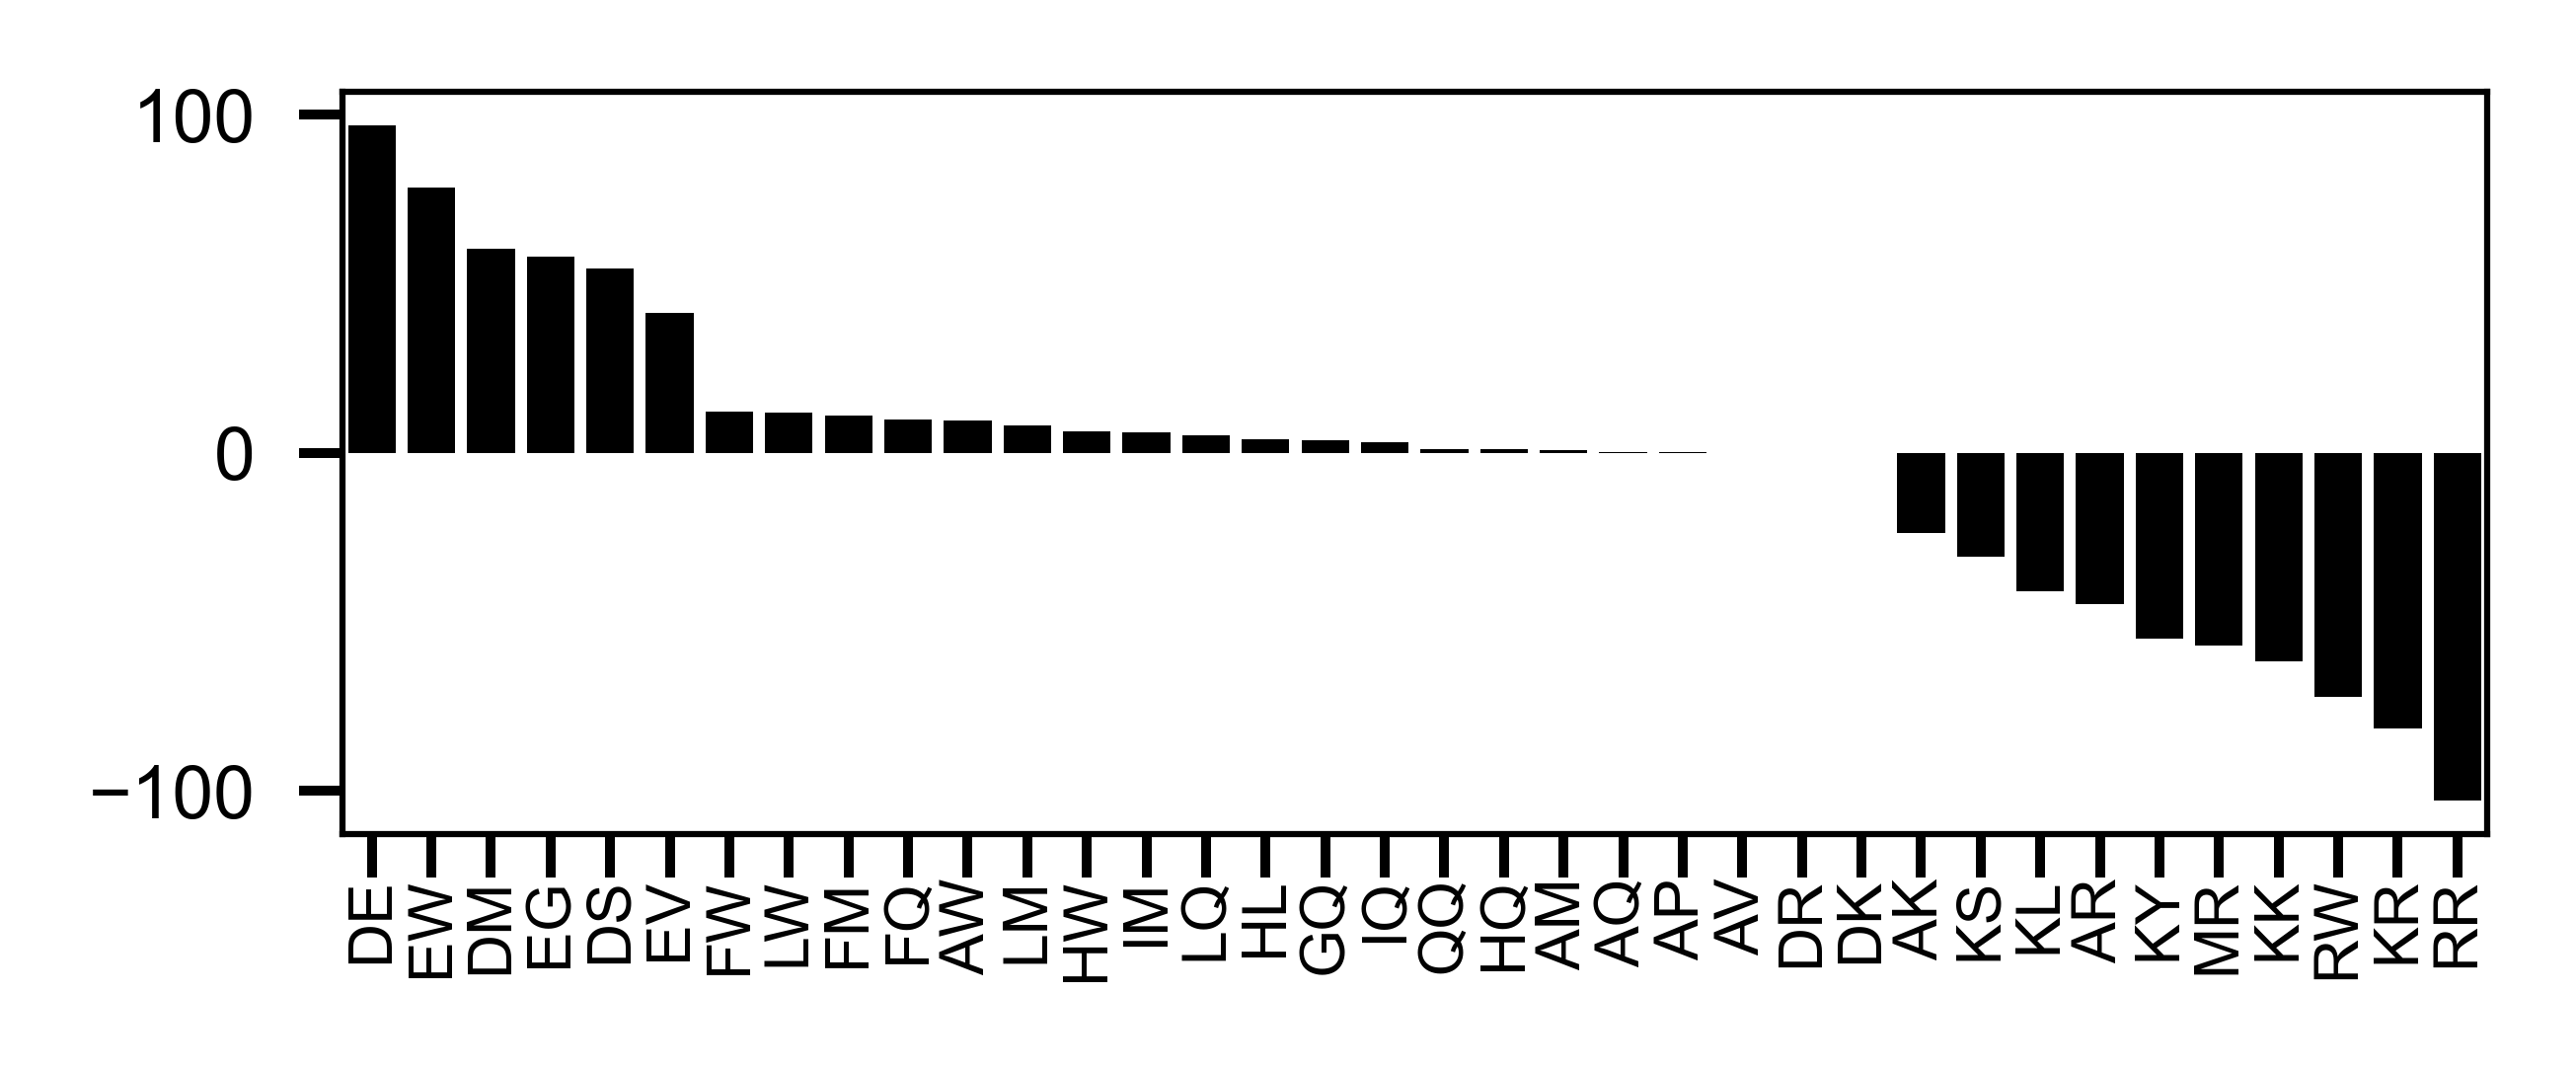

In [13]:
# This cell generates figure 4K
values = list(zero_minus_100_attractive_all_ordered.values())
correlation_defined = []
cmap = cm.get_cmap('PRGn')  # You can choose any colormap
local_names = []
for k in zero_minus_100_attractive_all_ordered:
    correlation_defined.append(chem2corr_att[k])
    local_names.append(k)
    
fig, ax = plt.subplots(figsize=(3, 1.3), dpi=450)

bars = ax.bar(range(len(values)), values, color='k')
plt.xticks(range(len(values)), [x.split('_')[0] for x in local_names], rotation=90, fontsize=5,ha='center')
plt.yticks(fontsize=6)
ax.tick_params(axis='x', pad=0)  # Adjust '10' to control the gap


#plt.ylim([-11, 11])


# Create a ScalarMappable and add the colorbar
plt.xlim([-0.5,35.5])
plt.tight_layout()
print('')
plt.savefig('outfigs/predicted_surface_interactions.pdf')

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_47528/4210976407.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('PRGn')  # You can choose any colormap


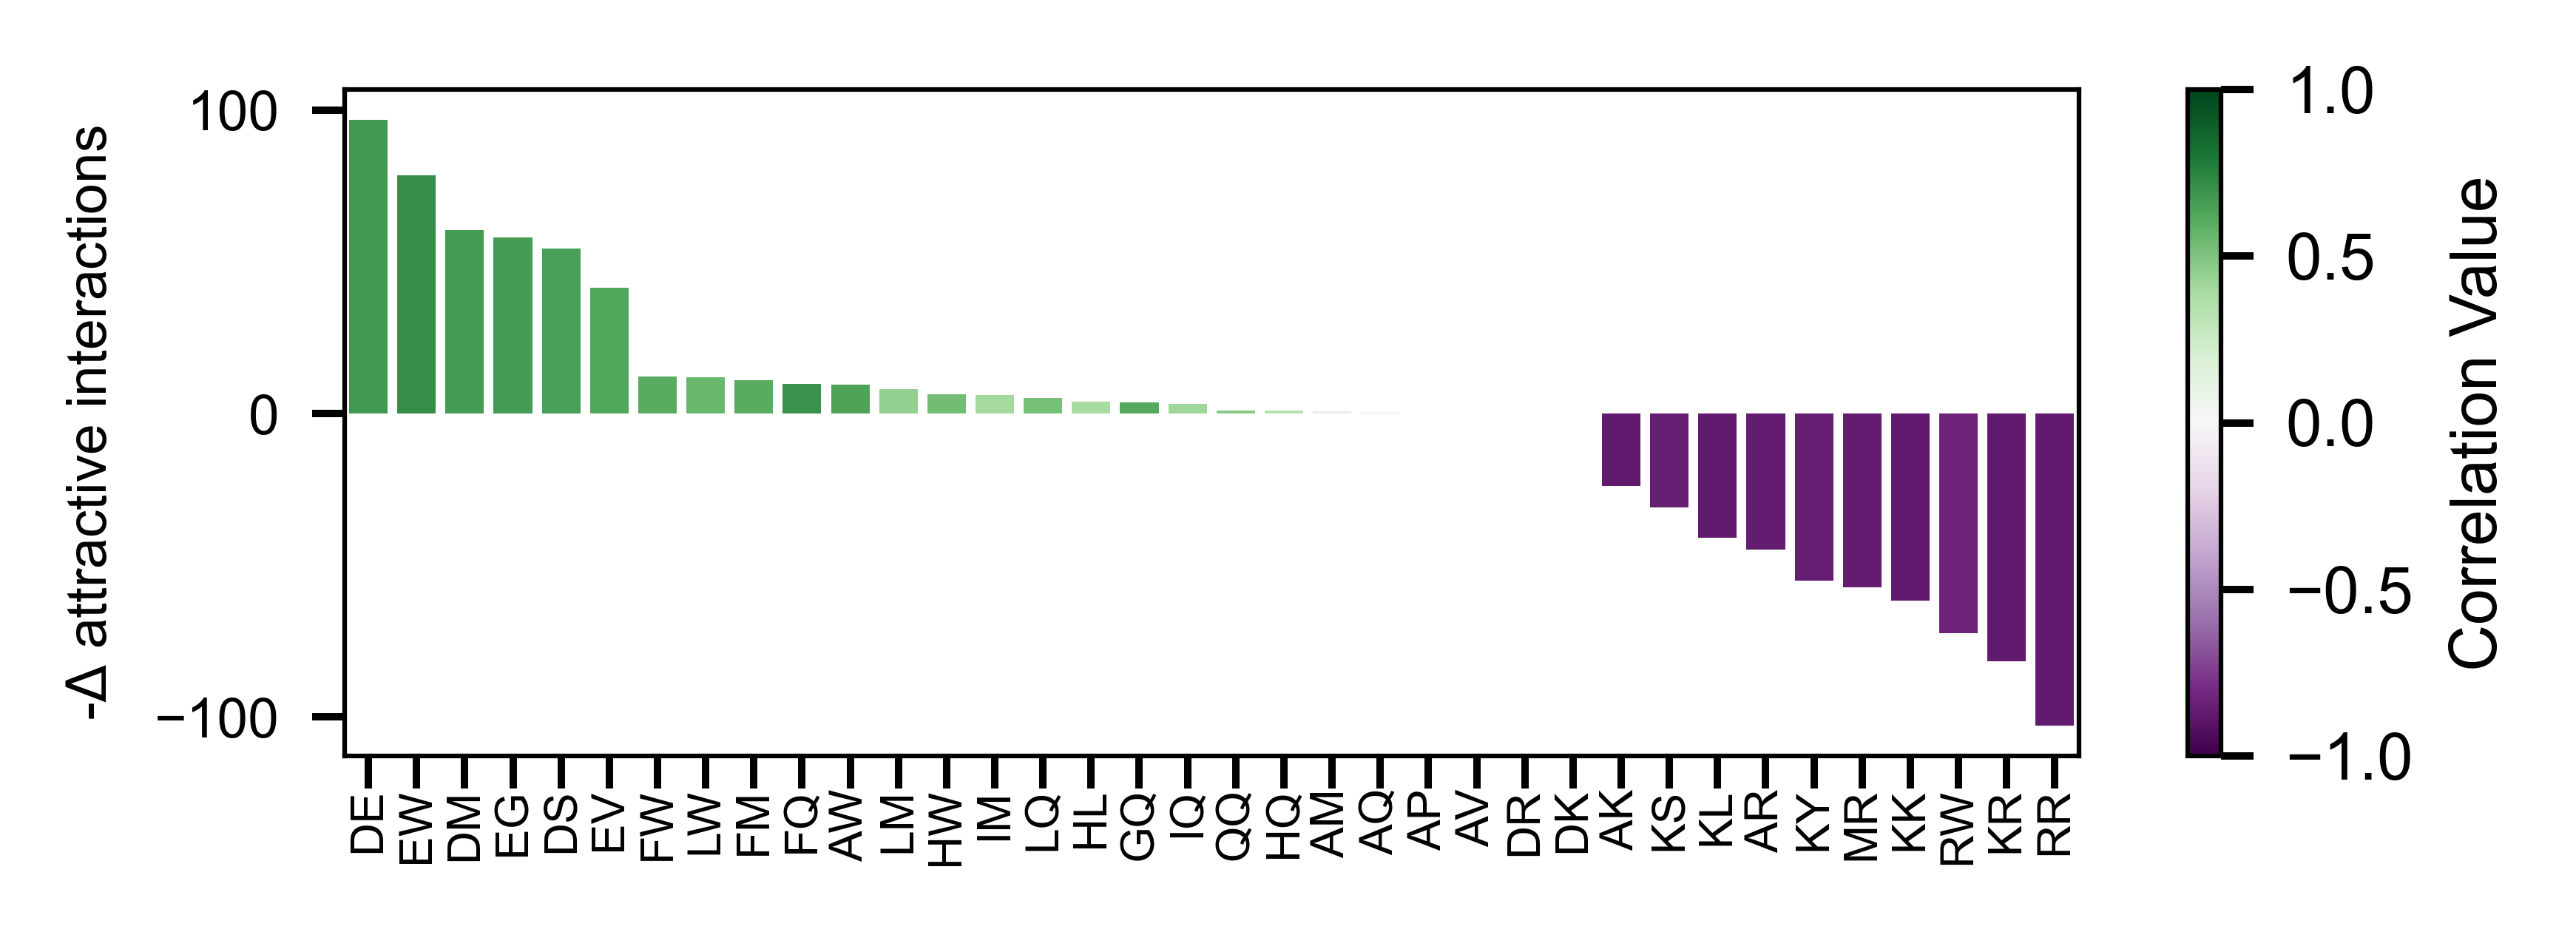

In [12]:
values = list(zero_minus_100_attractive_all_ordered.values())
correlation_defined = []
cmap = cm.get_cmap('PRGn')  # You can choose any colormap
local_names = []
for k in zero_minus_100_attractive_all_ordered:
    correlation_defined.append(chem2corr_att[k])
    local_names.append(k)
    

fig, ax = plt.subplots(figsize=(4, 1.5), dpi=450)


norm = Normalize(vmin=-1, vmax=1)
bars = ax.bar(range(len(values)), values, color=cmap(norm(correlation_defined)))
plt.xticks(range(len(values)), [x.split('_')[0] for x in local_names], rotation=90, fontsize=5,ha='center')
plt.yticks(fontsize=6)
ax.tick_params(axis='x', pad=0)  # Adjust '10' to control the gap


#plt.ylim([-11, 11])


# Create a ScalarMappable and add the colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the colorbar to be created
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Correlation Value', fontsize=7)
cbar.ax.tick_params(labelsize=7)  # Adjust '10' to your desired fontsize
plt.ylabel(r'-$\Delta$ attractive interactions', fontsize=6)
#plt.yscale('symlog')
plt.xlim([-0.5,35.5])
plt.tight_layout()
print('')
plt.savefig('outfigs/predicted_surface_interactions_with_exp_corr.pdf')

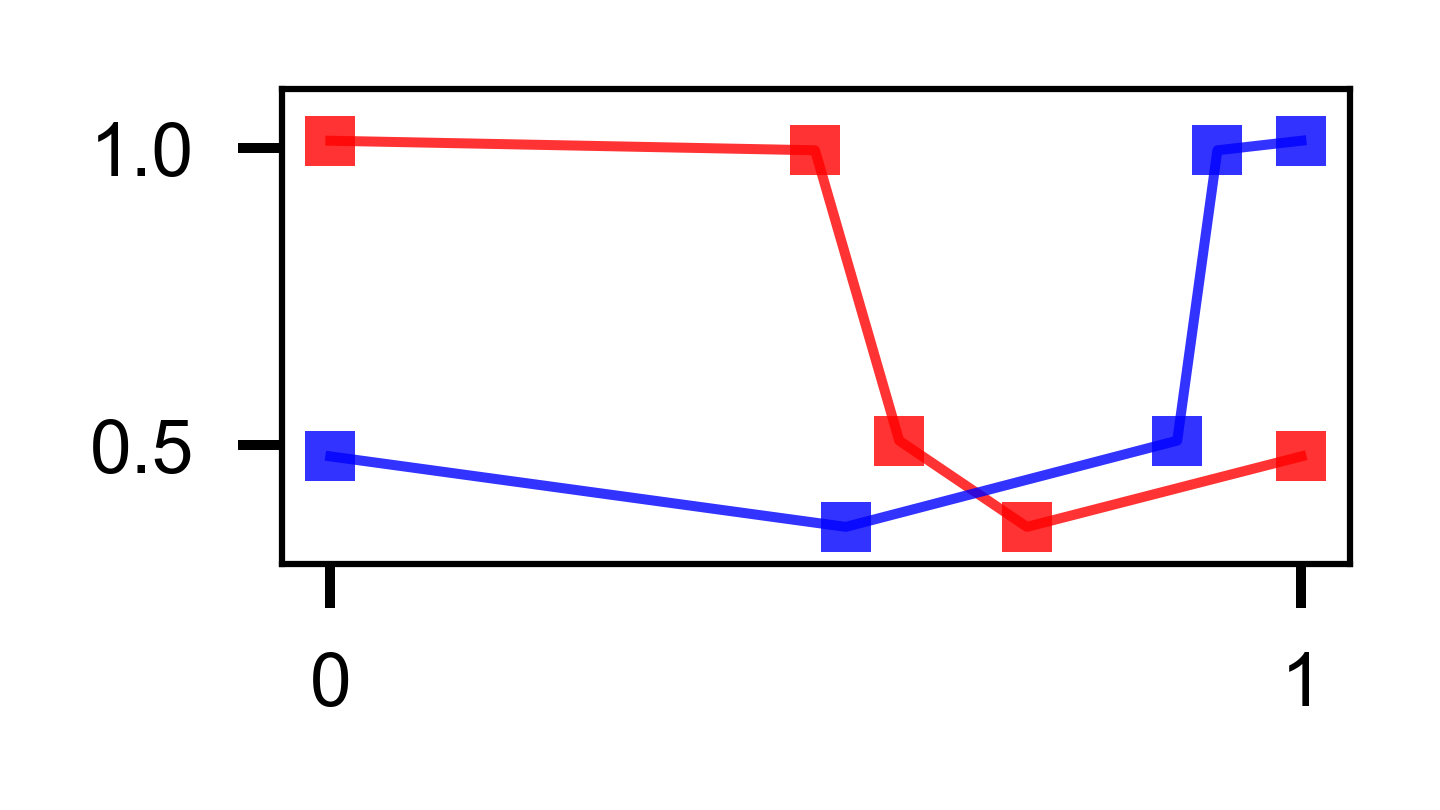

In [14]:
figure(None, (1.7,1), dpi=450)
c='EW'
vals = []
for d in fd2chem:
    vals.append(fd2chem[d][c][0])
plt.plot(normalize_array(vals)[::-1], average,'s-', color='red', ms=4, alpha=0.8, mew=0, lw=0.8)

c='KK'
vals = []
for d in fd2chem:
    vals.append(fd2chem[d][c][0])
plt.plot(normalize_array(vals)[::-1], average,'s-', color='blue', ms=4, alpha=0.8, mew=0, lw=0.8)
plt.ylim([0.3,1.1])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig('outfigs/EW_KK.pdf')


    
    

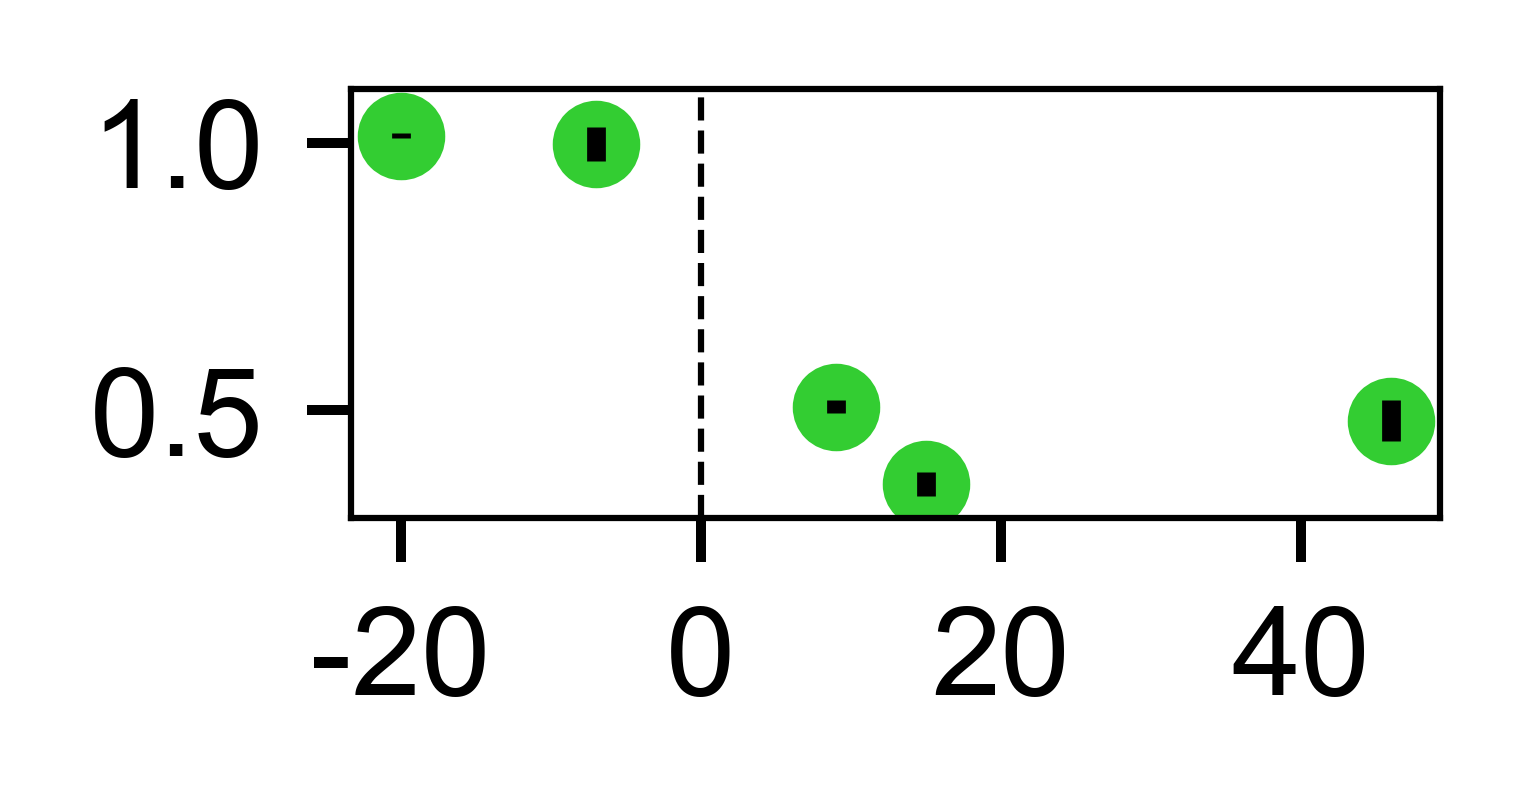

In [15]:
figure(None, (1.8,1), dpi=450)
ax = plt.gca()
plt.plot(charges, average, 'o',color='#33CD32')
plt.errorbar(charges, average, std,fmt='o',color='k',ms=0)
plt.xticks([-20,0,20,40],[-20,0,20,40])

#plt.xlim([-0.7,0.7])
plt.ylim([0.3, 1.1])


ax.axvline(0, ls='--',c='k',lw=0.5)
plt.tight_layout()
plt.savefig('outfigs/charge_fraction.pdf')

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_47528/2728731894.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sk" (-> color='k'). The keyword argument will take precedence.
  plt.plot(vals, average, 'sk', lw=0.4, color='#33CD32',mec='k',mew=0.3)


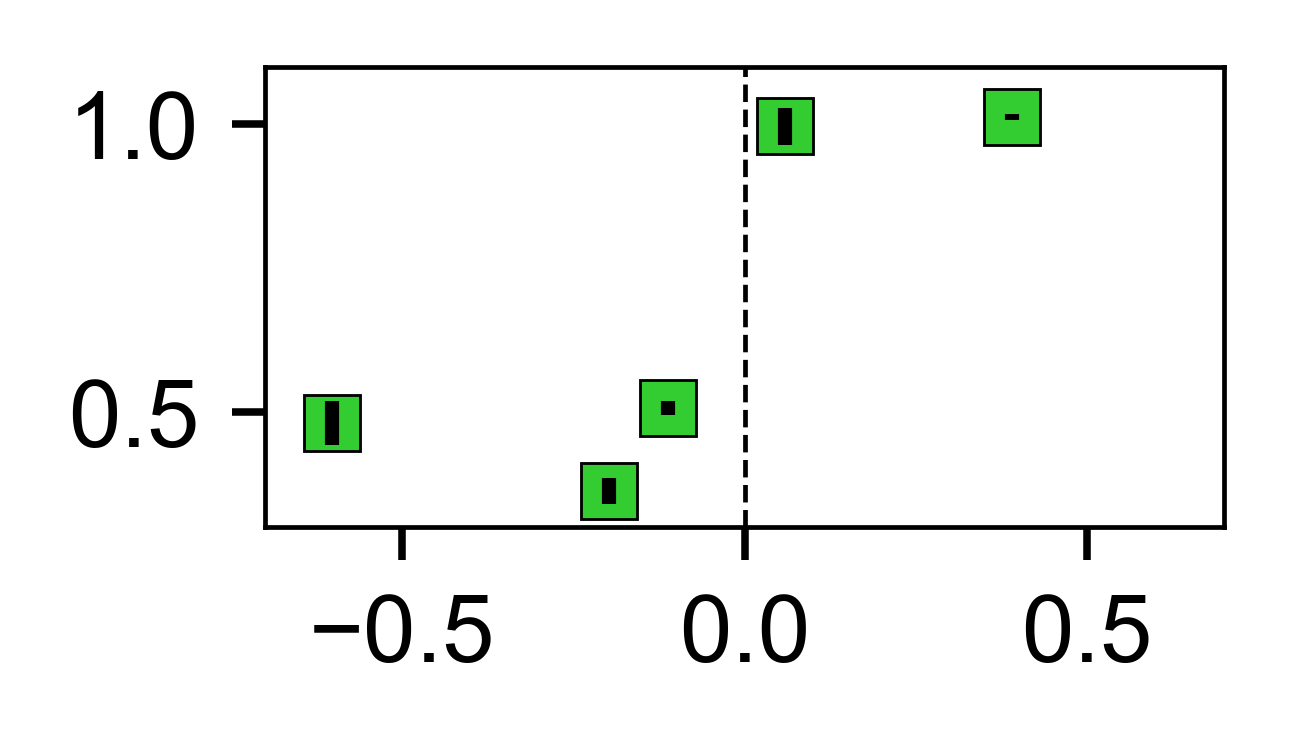

In [16]:
figure(None, (2, 1.2), dpi=340)
ax = plt.gca()
c = 'EG'
vals = []
for d in fd2chem:
    vals.append(fd2chem[d][c][2])

plt.plot(vals, average, 'sk', lw=0.4, color='#33CD32',mec='k',mew=0.3)
plt.errorbar(vals, average, std,fmt='o',color='k',ms=0)

ax.axvline(0, c='k', lw=0.5, ls='--')
plt.xlim([-0.7,0.7])
plt.ylim([0.3, 1.1])
plt.tight_layout()


